## Social Media from Conflict Zones
### Text analysis of social media posts from Syria

**Michael L. Davies**  
**mld9s**

**Section One: Pre-processing and building dataframes**
* View the data and set the OHCO configurations
* Initial exploratory plot of the word frequencies without preprocessing
* Preprocess the data, including generating parts-of-speech and TF-IDF
* Plot the results from pre-processing
* Build TOKEN, VOCAB, LIB, BOW, DTM/DTCM dataframes

**Section Two: Sentiment Analysis**
* Generate sentiments and polarity using the given sentiment analysis lexicon
* Plotting polarity grouped by token ID, province, and over time
* Plot distributions of emotions (anger, trust, etc)
* HTML plot of sentiments at the sentence level
* VADER plots for comparison

**Section Three: Topic Modelling**
* Generate and plot THETA and PHI
* Plot topics (sorted)
* Plot topics by province
* Scatter plot comparing topics by two provinces

**Section Four: Cluster Analysis**
* Plot clusters (dendogram) of topics

**Section Five: Classification - conventional pipelines**
* Leverage spaCy
* Neural Networks - Keras/TensorFlow

**Implementation in R included in separate files**

In [1]:
# Importing modules
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import plotly_express as px
%matplotlib inline

import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets') #part-of-speech tagging

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

### Data

In [2]:
# read in data
df_raw = pd.read_csv('df_acled_syr_2017_2021.csv', encoding = 'utf-8')
print(df_raw.shape)

(85104, 25)


In [3]:
# select columns of interest
df = df_raw[['country', 'year', 'event_date', 'admin1', 'admin2',
           'event_type', 'sub_event_type', 'fatalities', 
           'actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2', 
           'notes', 'longitude', 'latitude', 'event_id_cnty']].sample(1000).\
            reset_index()

df.rename(columns = {'event_id_cnty':'token_id'},inplace = True)
df.event_date = pd.to_datetime(df.event_date, errors='coerce')

# create copy so I have two df's to work with
df_copy = df.copy()

print(df.shape)

(1000, 17)


In [4]:
df_copy = df_copy[['token_id', 'country', 'year', 'event_date', 'admin1', 'admin2','notes']]
df_copy.head()

token_id country  year event_date          admin1          admin2  \
0  SYR30608   Syria  2018 2018-03-28  Rural Damascus  Rural Damascus   
1  SYR11789   Syria  2017 2017-08-29            Hama        Muhradah   
2  SYR40167   Syria  2017 2017-05-25            Hama    As-Salamiyeh   
3  SYR55650   Syria  2018 2018-03-20        Damascus        Damascus   
4  SYR64093   Syria  2019 2019-07-13           Idleb        Al Ma'ra   

                                               notes  
0  Displacement: The fifth wave of the rebel figh...  
1  Shells fell on area of the regime-controlled t...  
2  Fierce clashes broke between regime and IS for...  
3  Russian warplanes carried out airstrikes on Al...  
4  On 13 July, 2019, Syrian and Russian warplanes...

### Configure the OHCO

In [5]:
# set configs for OHCO
OHCO = ['country', 'year', 'event_date', 'admin1', 'admin2','token_id', 'token_num']

DATE = OHCO[:3]
ADMIN1 = OHCO[:4]
SENTS = OHCO[:6]

df = df.groupby(OHCO[:6]).notes.apply(lambda x: '\n'.join(x)).to_frame()
df.index.names = OHCO[:6]
df.head()

notes
country year event_date admin1         admin2      token_id                                                   
Syria   2017 2017-01-01 Aleppo         Jebel Saman SYR34472  Warplanes, suspected to be Russian, bombarded ...
             2017-01-02 Idleb          Harim       SYR60     Unidentified warplane targeted a car in Sarmad...
             2017-01-04 Hama           Hama        SYR39282  Government forces shelled Harbanifse village i...
                        Rural Damascus Az-Zabdani  SYR62836  'On 4 January, 2017, 1 volunteer aid worker wa...
             2017-01-05 Aleppo         Al Bab      SYR23125  The Syrian army shelled and regime planes carr...

### Initial Exploratory Analysis of tokens
**With unprocessed data**

In [6]:
token_freq = pd.Series(' '.join(df['notes'])\
    .split())\
    .value_counts()[:20]\
    .to_frame().reset_index()\
    .rename(columns= {'index': 'token', 0: 'count'})

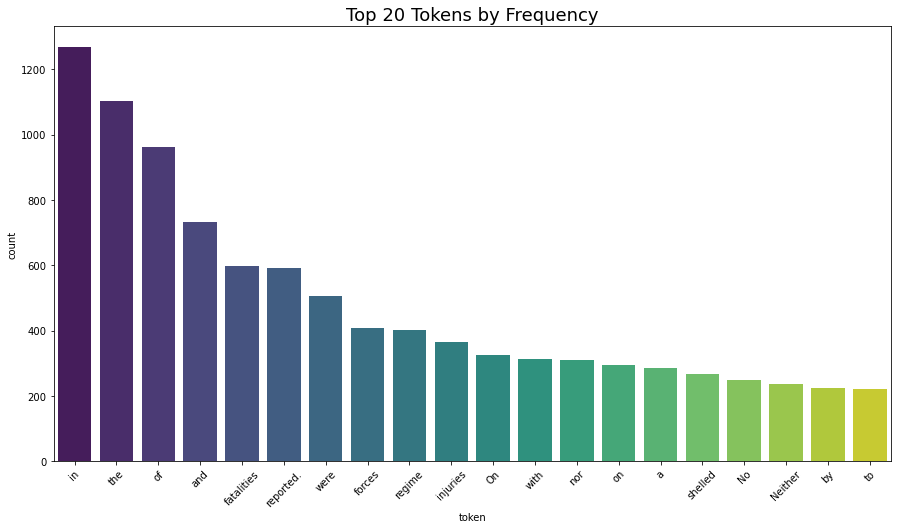

In [7]:
# Top 20 tokens by frequency
# https://pythonbasics.org/seaborn-barplot/
plt.figure(figsize=(15,8))
sns.barplot(x='token', y='count', data = token_freq,\
    palette = 'viridis')\
    .set_title('Top 20 Tokens by Frequency',
    fontsize = 18)
plt.xticks(rotation=45);

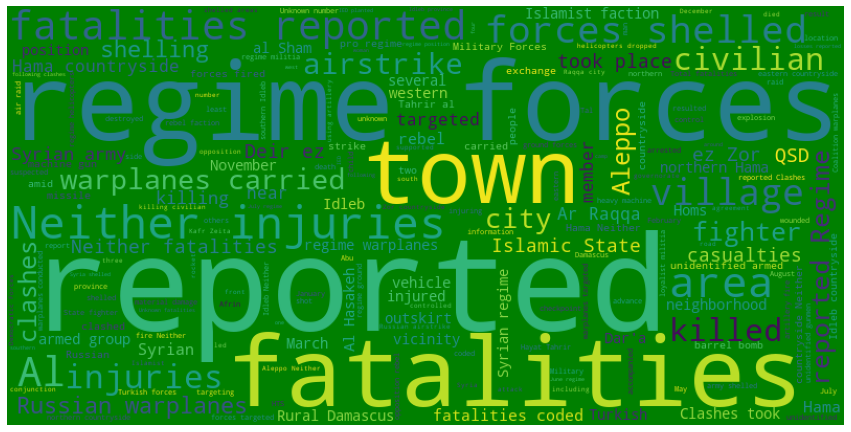

In [8]:
# Word Cloud using tokens from df.notes
# https://re-thought.com/creating-wordclouds-in-python/
text = " ".join(word for word in df.notes)
wordcloud = WordCloud(background_color="green", 
                      width=800, 
                      height=400)\
    .generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

### Pre-process data

In [9]:
from nltk import word_tokenize, pos_tag, pos_tag_sents
import pandas as pd

OHCO = ['country', 'year', 'event_date', 'admin1', 'admin2','token_id']
df_copy.head()

token_id country  year event_date          admin1          admin2  \
0  SYR30608   Syria  2018 2018-03-28  Rural Damascus  Rural Damascus   
1  SYR11789   Syria  2017 2017-08-29            Hama        Muhradah   
2  SYR40167   Syria  2017 2017-05-25            Hama    As-Salamiyeh   
3  SYR55650   Syria  2018 2018-03-20        Damascus        Damascus   
4  SYR64093   Syria  2019 2019-07-13           Idleb        Al Ma'ra   

                                               notes  
0  Displacement: The fifth wave of the rebel figh...  
1  Shells fell on area of the regime-controlled t...  
2  Fierce clashes broke between regime and IS for...  
3  Russian warplanes carried out airstrikes on Al...  
4  On 13 July, 2019, Syrian and Russian warplanes...

In [10]:
df_copy = df_copy.set_index(OHCO)
df_copy.head()

notes
country year event_date admin1         admin2         token_id                                                   
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608  Displacement: The fifth wave of the rebel figh...
        2017 2017-08-29 Hama           Muhradah       SYR11789  Shells fell on area of the regime-controlled t...
             2017-05-25 Hama           As-Salamiyeh   SYR40167  Fierce clashes broke between regime and IS for...
        2018 2018-03-20 Damascus       Damascus       SYR55650  Russian warplanes carried out airstrikes on Al...
        2019 2019-07-13 Idleb          Al Ma'ra       SYR64093  On 13 July, 2019, Syrian and Russian warplanes...

In [11]:
# custome tokenize function with parts of speech
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = doc_df.notes\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    # Add index
#     df.index.names = OHCO

    
    return df

In [12]:
TOKEN = tokenize(df_copy)
TOKEN = TOKEN[~TOKEN.pos.str.match('^NNP')]
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')
TOKEN.head()

pos_tuple  \
country year event_date admin1         admin2         token_id                         
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  (Displacement, NN)   
                                                               1              (:, :)   
                                                               2           (The, DT)   
                                                               3         (fifth, JJ)   
                                                               4          (wave, NN)   

                                                                 pos  \
country year event_date admin1         admin2         token_id         
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  NN   
                                                               1   :   
                                                               2  DT   
                                                               3  JJ   
                                                               4  NN   

                                                                     token_str  \
country year event_date admin1         admin2         token_id                   
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  Displacement   
                                                               1             :   
                                                               2           The   
                                                               3         fifth   
                                                               4          wave   

                                                                      term_str  
country year event_date admin1         admin2         token_id                  
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  displacement  
                                                               1                
                                                               2           the  
                                                               3         fifth  
                                                               4          wave

In [13]:
# counts get unique values with frequency, clean and create VOCAB table
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})

VOCAB.index.name = 'term_id'
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

VOCAB[VOCAB.stop == 1].sample(10)

term_str     n  num  stop
term_id                          
765       itself     1    0     1
919          off     1    0     1
262           at    79    0     1
321         both    26    0     1
233          any     1    0     1
693      himself     1    0     1
1285        them    11    0     1
1281        than     1    0     1
1286        then     3    0     1
720           in  1279    0     1

In [14]:
# stemming function
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

### POS Max

In [15]:
VOCAB = VOCAB.dropna()
TOKEN = TOKEN.dropna()

TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
TOKEN.head()

pos_tuple  \
country year event_date admin1         admin2         token_id                         
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  (Displacement, NN)   
                                                               1              (:, :)   
                                                               2           (The, DT)   
                                                               3         (fifth, JJ)   
                                                               4          (wave, NN)   

                                                                 pos  \
country year event_date admin1         admin2         token_id         
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  NN   
                                                               1   :   
                                                               2  DT   
                                                               3  JJ   
                                                               4  NN   

                                                                     token_str  \
country year event_date admin1         admin2         token_id                   
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  Displacement   
                                                               1             :   
                                                               2           The   
                                                               3         fifth   
                                                               4          wave   

                                                                      term_str  \
country year event_date admin1         admin2         token_id                   
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0  displacement   
                                                               1                 
                                                               2           the   
                                                               3         fifth   
                                                               4          wave   

                                                                  term_id  
country year event_date admin1         admin2         token_id             
Syria   2018 2018-03-28 Rural Damascus Rural Damascus SYR30608 0      496  
                                                               1        0  
                                                               2     1283  
                                                               3      591  
                                                               4     1378

In [16]:
VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos'])\
    .count()\
    .iloc[:,0]\
    .unstack()\
    .idxmax(1)

VOCAB.head()

term_str     n  num  stop p_stem pos_max
term_id                                         
0                 3166    0     0              .
1             02     3    1     0     02      CD
2             03     4    1     0     03      CD
3             04     2    1     0     04      CD
4             05     2    1     0     05      CD

In [17]:
POS = TOKEN.pos.value_counts()\
    .to_frame()\
    .rename(columns={'pos':'n'})

POS.index.name = 'pos_id'

**Plot of distributions of parts of speech**

Next three plots show distributions dominated by nouns.

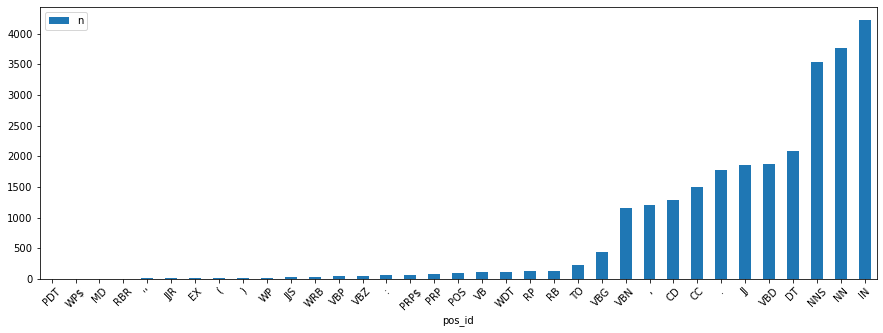

In [18]:
POS.sort_values('n').plot.bar(y='n', figsize=(15,5), rot=45);

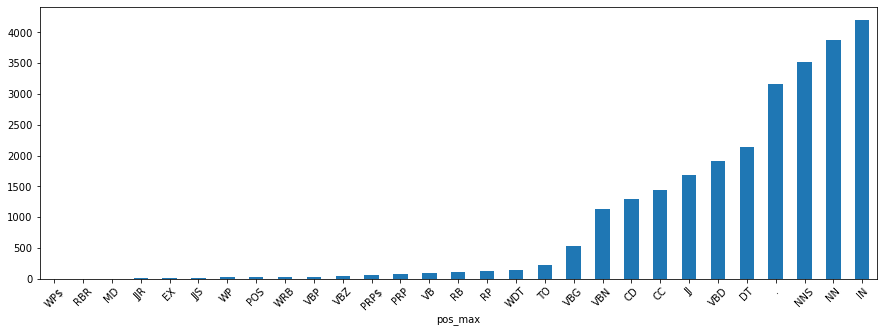

In [19]:
POS_MAX = VOCAB.pos_max.value_counts().to_frame().rename(columns={'pos_max':'n'})
POS_MAX.index.name = 'pos_id'

VOCAB.groupby('pos_max').n.sum().sort_values().plot.bar(figsize=(15,5), rot=45);

In [20]:
POS['max_n'] = POS_MAX['n']
POS.head()

n  max_n
pos_id             
IN      4222   39.0
NN      3762  414.0
NNS     3537  207.0
DT      2088   13.0
VBD     1868  121.0

In [21]:
# import plotly_express as px
fig = px.scatter(POS.reset_index(), x='n', y='max_n', text='pos_id')
fig.data[0].update(mode='text')
fig.show()

In [22]:
# get rank and sort
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')
VOCAB['term_rank'] = VOCAB.n.map(new_rank.term_rank2) + 1

VOCAB['p'] = VOCAB.n / TOKEN.shape[0]
VOCAB.head()

term_str     n  num  stop p_stem pos_max  term_rank         p
term_id                                                              
0                 3166    0     0              .          1  0.121938
1             02     3    1     0     02      CD        108  0.000116
2             03     4    1     0     03      CD        107  0.000154
3             04     2    1     0     04      CD        109  0.000077
4             05     2    1     0     05      CD        109  0.000077

**Scatter plots of pos by frequency**

Plots shows the expected distribution

In [23]:
# Scatter of pos by frequency
px.scatter(VOCAB[VOCAB.term_rank <= 10000], 
           x='term_rank', y='n', 
           log_y=False, 
           log_x=False, 
           hover_name='term_str', 
           color='pos_max')

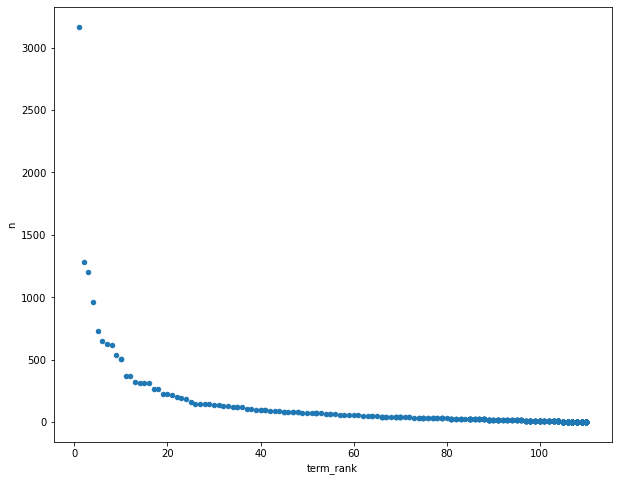

In [24]:
VOCAB.plot.scatter('term_rank', 'n', figsize=(10,8));

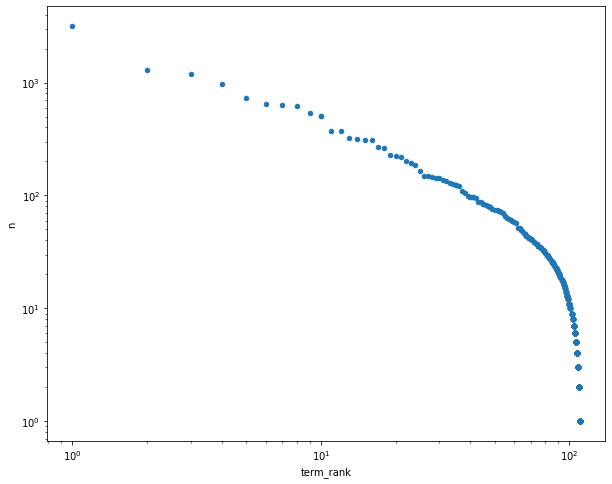

In [25]:
VOCAB.plot.scatter('term_rank', 'n', 
                   figsize=(10,8), 
                   logx=True, 
                   logy=True);

### Bag o' Words

In [26]:
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB.head()

term_str     n  num  stop p_stem pos_max  term_rank         p
term_id                                                              
0                 3166    0     0              .          1  0.121938
1             02     3    1     0     02      CD        108  0.000116
2             03     4    1     0     03      CD        107  0.000154
3             04     2    1     0     04      CD        109  0.000077
4             05     2    1     0     05      CD        109  0.000077

In [27]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'raw' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'GnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 
bag = ADMIN1

# recall, we chose "chapters" for the bag
# and add term ids, get a count, which turns it into a series, so turn it to a frame, rename the columns
BOW = TOKEN.groupby(bag+['term_id'])\
    .term_id.count()\
    .to_frame()\
    .rename(columns={'term_id':'n'})


# create a boolean that shows a 1 for each term, need for a matrix later
BOW['c'] = BOW.n.astype('bool').astype('int')
BOW.head()

n  c
country year event_date admin1 term_id      
Syria   2017 2017-01-01 Aleppo 0        4  1
                               287      1  1
                               311      1  1
                               429      1  1
                               581      1  1

### Document-Term Matrix

In [28]:
# convert into a count matrix
# use "n" or "c" - (count_method) established at the top
# unstack takes the last column of the index level and project it across the columns
DTCM = BOW[count_method].unstack().fillna(0).astype('int')
DTCM.head(10)

term_id                                 0     1     2     3     4     5     \
country year event_date admin1                                               
Syria   2017 2017-01-01 Aleppo             4     0     0     0     0     0   
             2017-01-02 Idleb              9     0     0     0     0     0   
             2017-01-04 Hama               2     0     0     0     0     0   
                        Rural Damascus     5     0     0     0     0     0   
             2017-01-05 Aleppo             2     0     0     0     0     0   
             2017-01-07 Hama               2     0     0     0     0     0   
             2017-01-09 Aleppo             2     0     0     0     0     0   
             2017-01-10 Hama               5     0     0     0     0     0   
                        Idleb              2     0     0     0     0     0   
                        Lattakia           2     0     0     0     0     0   

term_id                                 6     7     8     9     ...  1422  \
country year event_date admin1                                  ...         
Syria   2017 2017-01-01 Aleppo             0     0     0     0  ...     0   
             2017-01-02 Idleb              0     0     0     0  ...     0   
             2017-01-04 Hama               0     0     0     0  ...     0   
                        Rural Damascus     0     0     0     1  ...     0   
             2017-01-05 Aleppo             0     0     0     0  ...     0   
             2017-01-07 Hama               0     0     0     0  ...     0   
             2017-01-09 Aleppo             0     0     0     0  ...     0   
             2017-01-10 Hama               0     0     0     0  ...     0   
                        Idleb              0     0     0     0  ...     0   
                        Lattakia           0     0     0     0  ...     0   

term_id                                 1423  1424  1425  1426  1427  1428  \
country year event_date admin1                                               
Syria   2017 2017-01-01 Aleppo             0     0     0     0     0     0   
             2017-01-02 Idleb              0     0     0     0     0     0   
             2017-01-04 Hama               0     0     0     0     0     0   
                        Rural Damascus     0     0     0     0     0     0   
             2017-01-05 Aleppo             0     0     0     0     0     0   
             2017-01-07 Hama               0     0     0     0     0     0   
             2017-01-09 Aleppo             0     0     0     0     0     0   
             2017-01-10 Hama               0     0     0     0     0     0   
                        Idleb              0     0     0     0     0     0   
                        Lattakia           0     0     0     0     0     0   

term_id                                 1429  1430  1431  
country year event_date admin1                            
Syria   2017 2017-01-01 Aleppo             0     0     0  
             2017-01-02 Idleb              0     0     0  
             2017-01-04 Hama               0     0     0  
                        Rural Damascus     0     0     0  
             2017-01-05 Aleppo             0     0     0  
             2017-01-07 Hama               0     0     0  
             2017-01-09 Aleppo             0     0     0  
             2017-01-10 Hama               0     0     0  
                        Idleb              0     0     0  
                        Lattakia           0     0     0  

[10 rows x 1432 columns]

### TF-IDF

In [29]:
print('TF method:', tf_method)
if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()
elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'log':
    TF = np.log10(1 + DTCM.T)
elif tf_method == 'raw':
    TF = DTCM.T
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
TF = TF.T

TF method: raw


In [30]:
# Compute DF
DF = DTCM[DTCM > 0].count()

# Compute IDF
N = DTCM.shape[0]
print('IDF method:', idf_method)
if idf_method == 'standard':
    IDF = np.log10(N / DF)
elif idf_method == 'max':
    IDF = np.log10(DF.max() / DF) 
elif idf_method == 'smooth':
    IDF = np.log10((1 + N) / (1 + DF)) + 1
    
### Compute IDF
TFIDF = TF * IDF

IDF method: standard


In [31]:
VOCAB.head()

term_str     n  num  stop p_stem pos_max  term_rank         p
term_id                                                              
0                 3166    0     0              .          1  0.121938
1             02     3    1     0     02      CD        108  0.000116
2             03     4    1     0     03      CD        107  0.000154
3             04     2    1     0     04      CD        109  0.000077
4             05     2    1     0     05      CD        109  0.000077

In [32]:
VOCAB['df'] = DF
VOCAB['idf'] = IDF

VOCAB['tfidf_mean'] = TFIDF[TFIDF > 0].mean().fillna(0) # EXPLAIN
VOCAB['tfidf_sum'] = TFIDF.sum()
VOCAB['tfidf_median'] = TFIDF[TFIDF > 0].median().fillna(0) # EXPLAIN
VOCAB['tfidf_max'] = TFIDF.max()

BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

In [33]:
VOCAB.head()

term_str     n  num  stop p_stem pos_max  term_rank         p   df  \
term_id                                                                      
0                 3166    0     0              .          1  0.121938  936   
1             02     3    1     0     02      CD        108  0.000116    3   
2             03     4    1     0     03      CD        107  0.000154    4   
3             04     2    1     0     04      CD        109  0.000077    2   
4             05     2    1     0     05      CD        109  0.000077    2   

              idf  tfidf_mean  tfidf_sum  tfidf_median  tfidf_max  
term_id                                                            
0        0.000000    0.000000   0.000000      0.000000   0.000000  
1        2.494155    2.494155   7.482464      2.494155   2.494155  
2        2.369216    2.369216   9.476863      2.369216   2.369216  
3        2.670246    2.670246   5.340492      2.670246   2.670246  
4        2.670246    2.670246   5.340492      2.670246   2.670246

In [34]:
px.scatter(VOCAB, x='term_rank', 
           y='tfidf_mean', 
           hover_name='term_str', 
           hover_data=['n'], color='pos_max', 
           log_x=False, log_y=False)

In [35]:
px.scatter(VOCAB, x='term_rank', 
           y='tfidf_sum', 
           hover_name='term_str', 
           hover_data=['n'], 
           color='pos_max')

## Sentiment Analysis

* First with salex (sentiment analysis lexicon)
* Next with VADER pretrained data

**Analytic focus on sentiments by province and over time**

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML

In [37]:
sns.set()
%matplotlib inline

In [38]:
salex = pd.read_csv('salex_nrc.csv').set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]

salex['polarity'] = salex.positive - salex.negative

#salex.head()

# a subset of emotions to select just these columns
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [39]:
TOKEN = TOKEN.join(salex, on = 'term_str', how='left')
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)

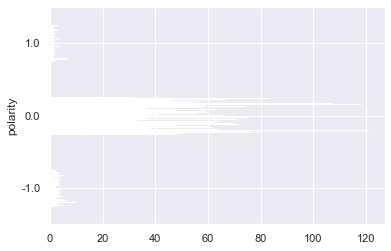

In [40]:
TOKEN.groupby('token_id')\
    .polarity.value_counts()\
    .unstack(0)\
    .plot.barh()\
    .get_legend().remove()

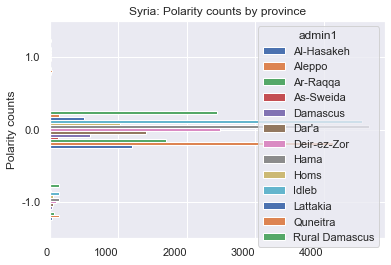

In [41]:
#plot polarity for all provinces
TOKEN.groupby('admin1')\
    .polarity.value_counts()\
    .unstack(0).plot.barh()

plt.title('Syria: Polarity counts by province');
plt.xlabel('');
plt.ylabel('Polarity counts');
plt.xticks(rotation=0, horizontalalignment='right');
plt.rcParams['figure.figsize'] = [14,12] #[width, height]
#plt.show()
#plt.savefig("FatalitiesByProvince.jpg")

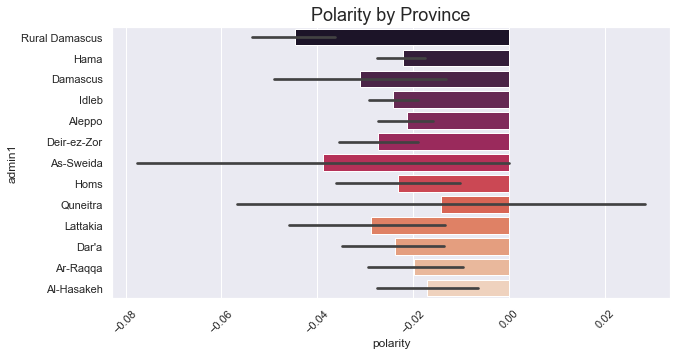

In [42]:
# Create a bar plot to see the polarity values by Province. 
plt.figure(figsize=(10,5))
sns.barplot(x='polarity', 
    y='admin1', 
    data = TOKEN.reset_index(),\
    palette = 'rocket')\
    .set_title('Polarity by Province',fontsize = 18)

plt.xticks(rotation=45);

**Sentiments over time**

**Get the 1st and 2nd derivative and moving average to smooth the lines**

In [43]:
# get the 1st and 2nd derivative to smooth the lines
TOKEN['new_polarity'] = TOKEN.polarity.diff()
TOKEN['growth_new_polarity'] = TOKEN.new_polarity.diff()
TOKEN['mov_avg'] = TOKEN['new_polarity'].rolling(3).sum()

# w = int(TOKEN.polarity[0] / 10)
# TOKEN[['polarity']].rolling(w).mean().plot(figsize=(25,5));

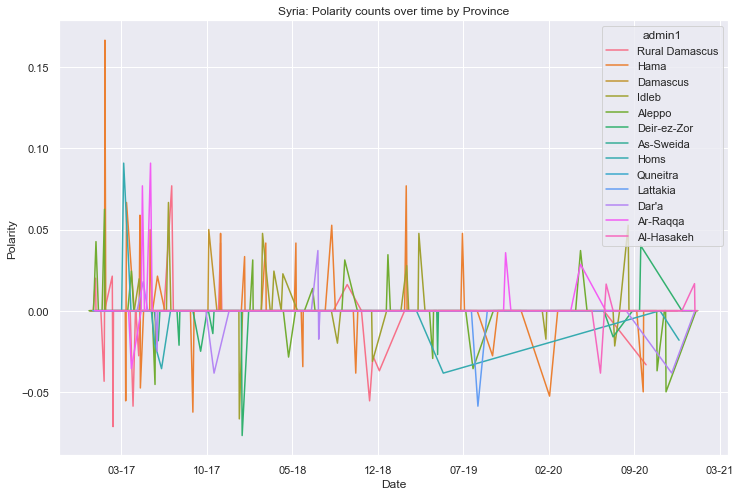

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.lineplot(
    x="event_date", 
    y="mov_avg", 
    hue="admin1", 
    data=TOKEN, 
    ci= None)

ax.set(xlabel="Date",
       ylabel="Polarity",
       title="Syria: Polarity counts over time by Province")

# Define the date format
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=30))

**Plot emotions**

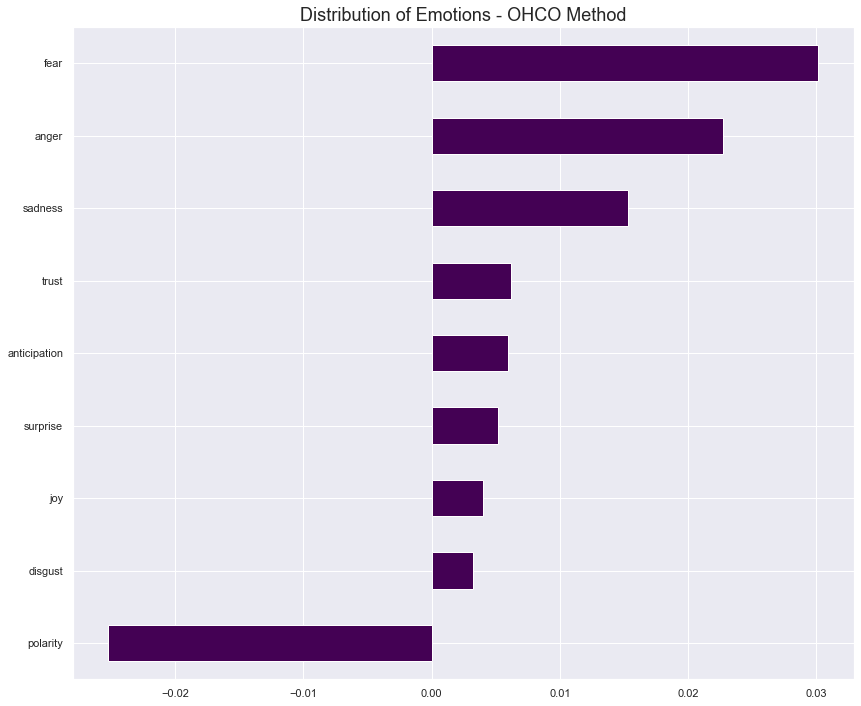

In [45]:
TOKEN[emo_cols].mean().sort_values().plot.barh(cmap='viridis')\
                .set_title('Distribution of Emotions - OHCO Method',fontsize = 18);

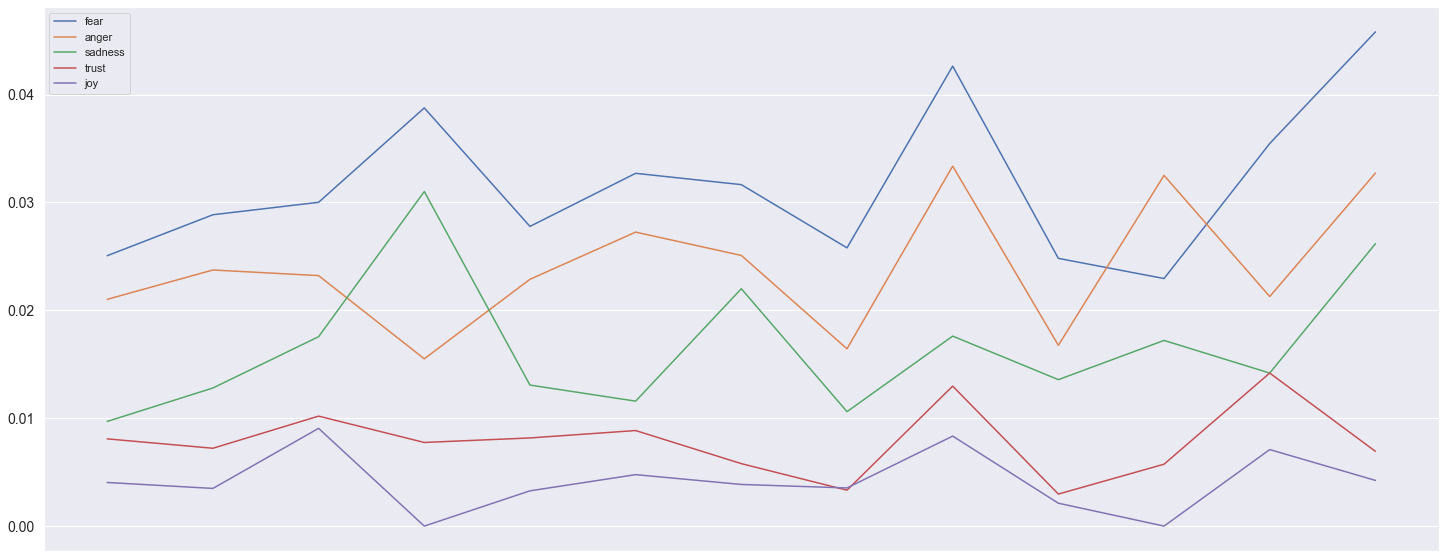

In [46]:
admin_emo_cols = TOKEN.groupby('admin1')[emo_cols].mean()

def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 10), legend=True, 
               fontsize=14, rot=45, xticks=())
    df[emo].plot(**FIG).axes.xaxis.set_visible(False)
    
plot_sentiments(admin_emo_cols, ['fear','anger','sadness','trust', 'joy'])

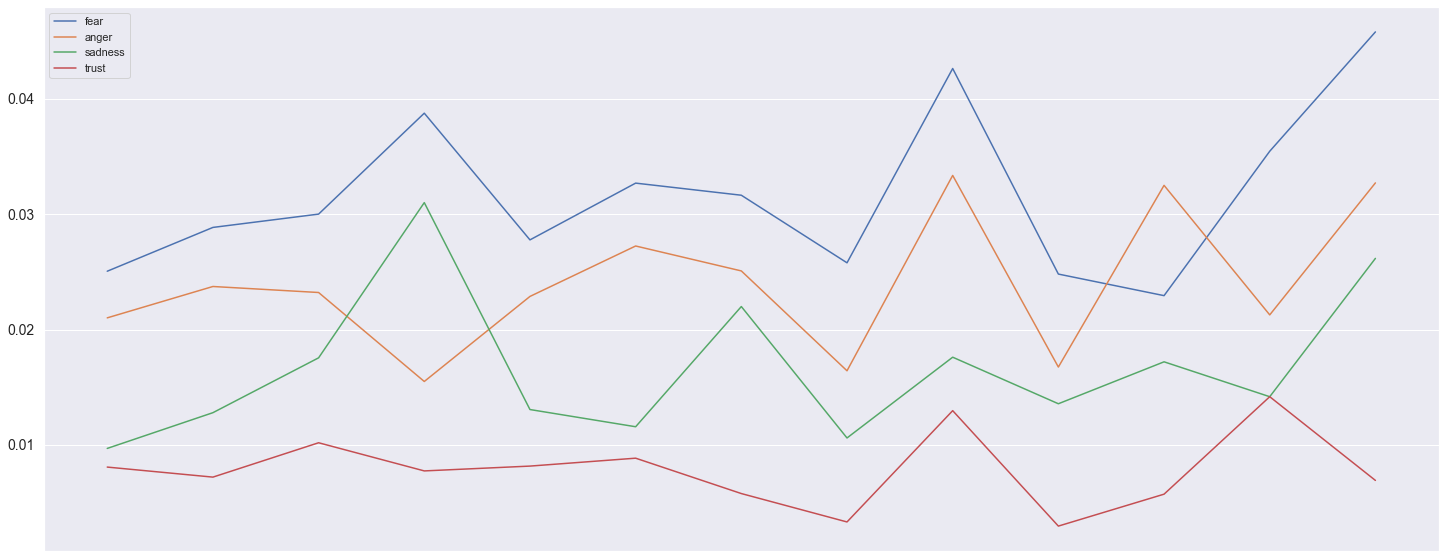

In [47]:
admin_emo_cols = TOKEN.groupby('admin1')[emo_cols].mean()

def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 10), legend=True, 
               fontsize=14, rot=45, xticks=())
    df[emo].plot(**FIG).axes.xaxis.set_visible(False)
    
plot_sentiments(admin_emo_cols, ['fear','anger','sadness','trust'])

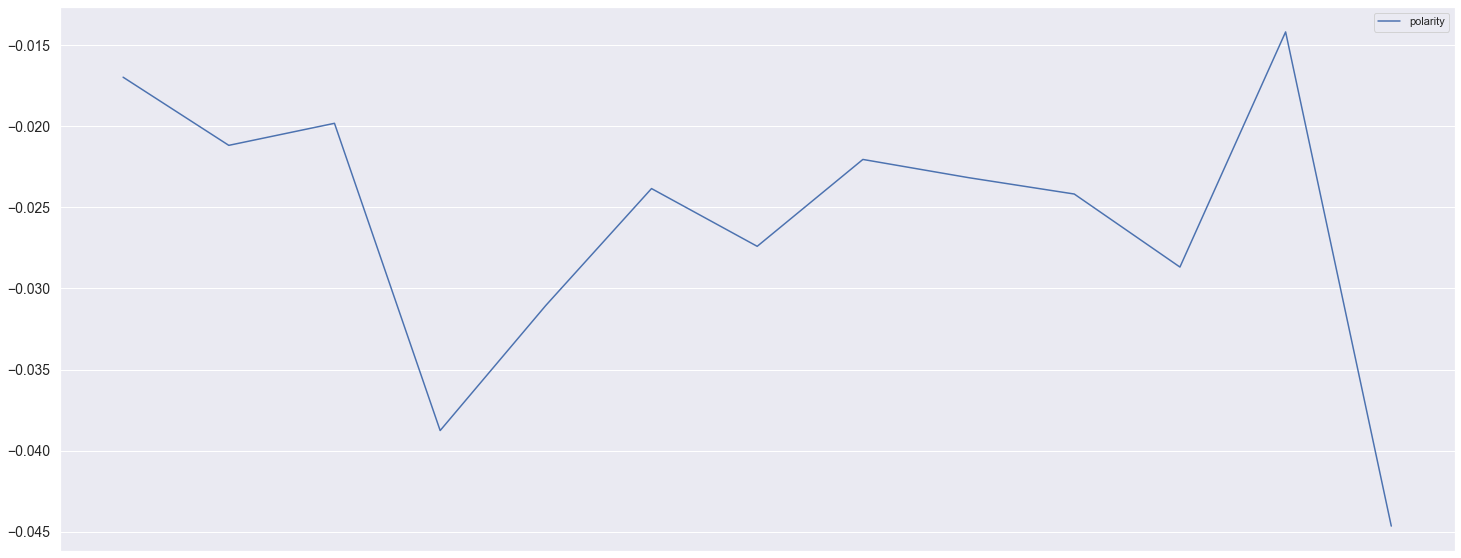

In [48]:
plot_sentiments(admin_emo_cols, ['polarity'])

### Explore Sentiment in at Sentence Level

In [49]:
emo = 'polarity'
TOKEN['html'] =  TOKEN\
    .apply(lambda x: "<span class='sent{}'>{}</span>"\
    .format(int(np.sign(x[emo])), x.token_str), 1)
#TOKEN['html'].sample(10)

# Now at sentence level
sents_polarity = TOKEN.groupby(SENTS)[emo_cols].mean()

sents_polarity['sent_str'] = TOKEN\
    .groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
sents_polarity['html_str'] = TOKEN\
    .groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [50]:
# a function to create some html to visualize the results

# NOTE - this just pulls a sample(10)
def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [51]:
sample_sentences(sents_polarity)

### VADER

In [52]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#!pip install vaderSentiment

In [53]:
# apply the analyzer to each sentence
# attach it to the DRACULA_sents table
vader_cols = sents_polarity.sent_str.apply(analyser.polarity_scores)\
    .apply(lambda x: pd.Series(x))
vader = pd.concat([sents_polarity, vader_cols], axis=1)

Positive and Negative

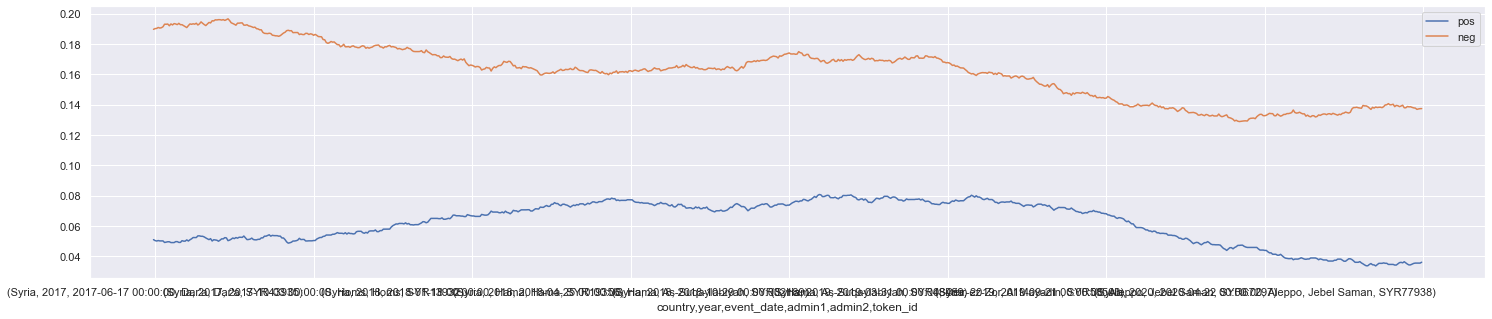

In [54]:
# using a rolling method to smooth the lines
# using 1/5 of the values
w = int(vader.shape[0] / 5)
vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5));

Neutral

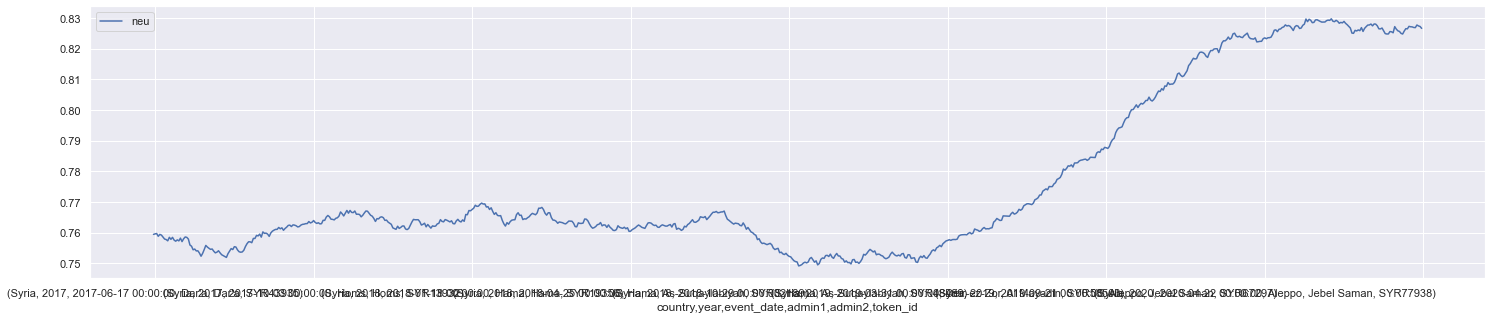

In [55]:
vader[['neu']].rolling(w).mean().plot(figsize=(25,5));

Compound - combination of pos and neg

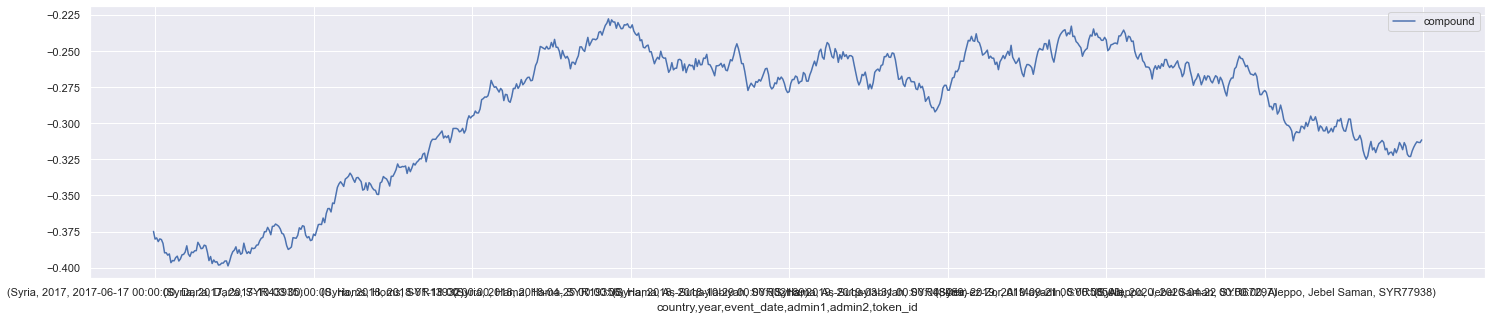

In [56]:
vader[['compound']].rolling(w).mean().plot(figsize=(25,5));

In [57]:
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

# https://madhuramiah.medium.com/geographic-plotting-with-python-folium-2f235cc167b7

# Topic Modeling

### Configs

In [58]:
n_terms = 4000
n_topics = 10
max_iter = 5

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

%matplotlib inline

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [59]:
# Create a vector space
tfv = CountVectorizer(max_features=n_terms, stop_words='english') 
tf = tfv.fit_transform(TOKEN.token_str)
TERMS = tfv.get_feature_names()

In [60]:
# Generate Model
# Scikit Learn's LatentDirichletAllocation algorithm and extract the THETA and PHI tables.
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

### THETA

In [61]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=TOKEN.index)
THETA.columns.name = 'topic_id'

In [62]:
THETA.sample(10).style.background_gradient()

### PHI

In [63]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [64]:
PHI.T.head().style.background_gradient()

### Inspect Results

Get Top Terms per Topic

In [65]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

TOPICS.head()

term_str            0        1         2             3         4        5  \
topic_id                                                                    
0                town       al   clashes     civilians  factions    rebel   
1            reported   syrian  military       strikes    number      man   
2         countryside     2020   carried  unidentified   killing    coded   
3            injuries  village   russian          near        10  turkish   
4              regime  shelled      2019    casualties   unknown      pro   

term_str          6             7            8            9  
topic_id                                                     
0             group  neighborhood       gunmen      planted  
1         targeting        people  accompanied     resulted  
2              army         armed        raids      machine  
3          province    opposition       ground  helicopters  
4            shells       vehicle   controlled       damage

### Sort Topics by Doc Weight

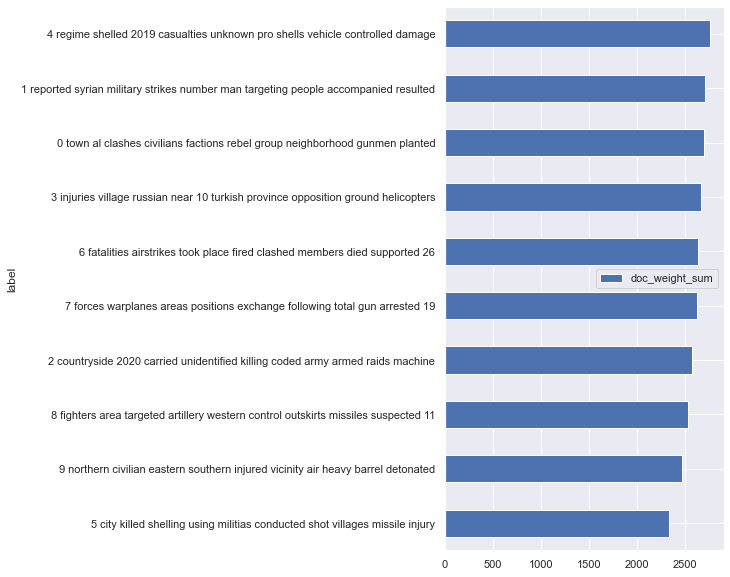

In [66]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

TOPICS['doc_weight_sum'] = THETA.sum()

TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)); 

### Explore Topics by Province

Sorted descending in terms of Idleb province, which seem to be the most volitile province.

In [67]:
#THETA.head()

topic_cols = [t for t in range(n_topics)]
ADMIN1 = THETA.groupby('admin1')[topic_cols].mean().T                                            
ADMIN1.index.name = 'topic_id'

#ADMIN1.T

ADMIN1['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

ADMIN1.sort_values('Idleb', ascending=False).style.background_gradient()

Comparing Idleb, which is dominated by hardline Arab opposition factions (largely backed by Turkey)
with Deir ez Zor province, which is Kurd dominated opposition (largely backed by the US).

In [68]:
import plotly_express as px

px.scatter(ADMIN1.reset_index(), 'Idleb', 'Deir-ez-Zor', hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

### Clutser Topics

In [69]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [70]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(14, 15))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left", truncate_mode='lastp')
    plt.tick_params(axis='both', which='major', labelsize=14)

In [71]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [72]:
labels  = ["{}: {}".format(a,b) for a, b in zip(ADMIN1.index,  ADMIN1.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

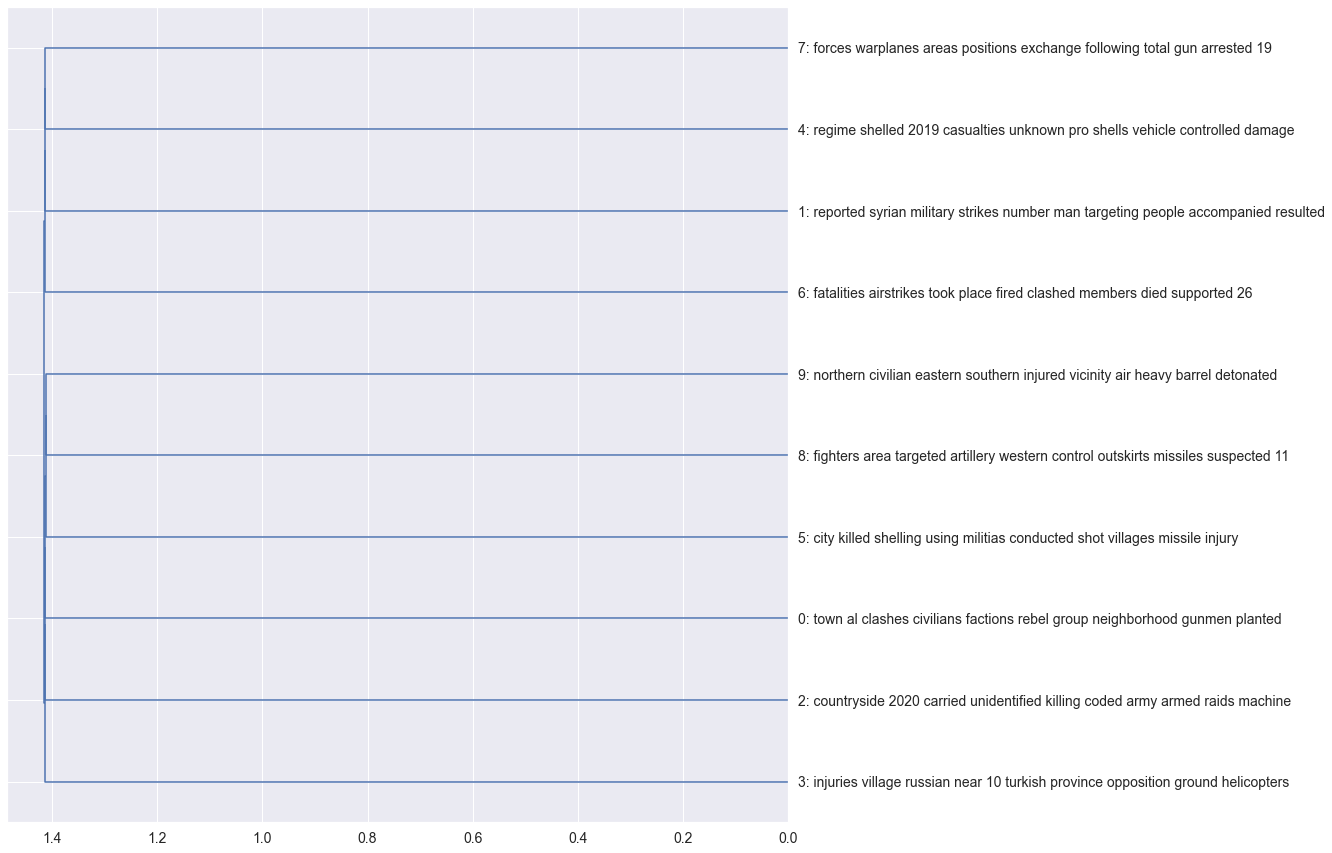

In [73]:
plot_tree(TREE, labels)

In [74]:
VOCAB.head()

term_str     n  num  stop p_stem pos_max  term_rank         p   df  \
term_id                                                                      
0                 3166    0     0              .          1  0.121938  936   
1             02     3    1     0     02      CD        108  0.000116    3   
2             03     4    1     0     03      CD        107  0.000154    4   
3             04     2    1     0     04      CD        109  0.000077    2   
4             05     2    1     0     05      CD        109  0.000077    2   

              idf  tfidf_mean  tfidf_sum  tfidf_median  tfidf_max  
term_id                                                            
0        0.000000    0.000000   0.000000      0.000000   0.000000  
1        2.494155    2.494155   7.482464      2.494155   2.494155  
2        2.369216    2.369216   9.476863      2.369216   2.369216  
3        2.670246    2.670246   5.340492      2.670246   2.670246  
4        2.670246    2.670246   5.340492      2.670246   2.670246

### Build VOCAB and LIB

In [75]:
# Create a LIB dataframe with product metadata
library = df_raw[['country','admin1','event_date']]
LIB = pd.DataFrame(library.groupby('admin1')['event_date'].unique())

# Export files to csv
LIB.to_csv('LIB.csv')
VOCAB.to_csv('VOCAB.csv')
TOKEN.to_csv('TOKEN.csv')

In [76]:
VOCAB.head()

term_str     n  num  stop p_stem pos_max  term_rank         p   df  \
term_id                                                                      
0                 3166    0     0              .          1  0.121938  936   
1             02     3    1     0     02      CD        108  0.000116    3   
2             03     4    1     0     03      CD        107  0.000154    4   
3             04     2    1     0     04      CD        109  0.000077    2   
4             05     2    1     0     05      CD        109  0.000077    2   

              idf  tfidf_mean  tfidf_sum  tfidf_median  tfidf_max  
term_id                                                            
0        0.000000    0.000000   0.000000      0.000000   0.000000  
1        2.494155    2.494155   7.482464      2.494155   2.494155  
2        2.369216    2.369216   9.476863      2.369216   2.369216  
3        2.670246    2.670246   5.340492      2.670246   2.670246  
4        2.670246    2.670246   5.340492      2.670246   2.670246

# Classification 
**Logistic Regression with train/test split**

* https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
* https://realpython.com/logistic-regression-python/
* https://www.analyticsvidhya.com/blog/2020/12/understanding-text-classification-in-nlp-with-movie-review-example-example/
* https://realpython.com/python-keras-text-classification/
* https://www.kaggle.com/kashnitsky/logistic-regression-tf-idf-baseline



In Python, I compete three classification approaches. First, I use a base line model, which is the simplest, form sklearn. Second, I leverage spaCy for preprocessing and added the TF-IDF module with the sklearn for classification. Last, I implemented a Keras neural network, which is a high-level language that sits on top of TensorFlow.

In [77]:
df_raw.columns

Index(['region', 'country', 'year', 'event_date', 'source', 'admin1', 'admin2',
       'admin3', 'location', 'event_type', 'sub_event_type', 'interaction',
       'fatalities', 'timestamp', 'actor1', 'assoc_actor_1', 'actor2',
       'assoc_actor_2', 'notes', 'longitude', 'latitude', 'geo_precision',
       'inter1', 'inter2', 'event_id_cnty'],
      dtype='object')

In [78]:
df_raw['sub_event_type'].unique()

array(['Abduction/forced disappearance', 'Armed clash',
       'Shelling/artillery/missile attack', 'Attack',
       'Remote explosive/landmine/IED', 'Air/drone strike',
       'Change to group/activity', 'Looting/property destruction',
       'Arrests', 'Violent demonstration', 'Peaceful protest', 'Grenade',
       'Other', 'Headquarters or base established',
       'Disrupted weapons use', 'Suicide bomb',
       'Excessive force against protesters', 'Protest with intervention',
       'Non-state actor overtakes territory', 'Mob violence', 'Agreement',
       'Sexual violence', 'Non-violent transfer of territory',
       'Government regains territory', 'Chemical weapon'], dtype=object)

In [79]:
event_list = ['Non-state actor overtakes territory','Government regains territory']
filtered_df = df_raw[df_raw['sub_event_type'].isin(event_list)]

# filtered_df['sub_event_type'] = filtered_df['sub_event_type']\
#     .map({'Non-state actor overtakes territory': 1, 'Government regains territory': 0})

filtered_df['sub_event_type'] = filtered_df['sub_event_type']\
    .apply(lambda x: 0 if x=='Non-state actor overtakes territory' else 1)

<ipython-input-79-cef13c77fde9>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
filtered_df['sub_event_type'].head()
filtered_df['sub_event_type'].value_counts()

1    1786
0    1769
Name: sub_event_type, dtype: int64

In [81]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

### spaCy

In [82]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
#stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

### Defining a Custom Transformer

In [83]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

### Vectorization Feature Engineering (TF-IDF)

In [84]:
#bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
bow_vector = CountVectorizer(max_features=n_terms, stop_words='english') 

In [85]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [86]:
from sklearn.model_selection import train_test_split

X = filtered_df['notes'] # the features to analyze
ylabels = filtered_df['sub_event_type'] # the labels

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

### Creating a Pipeline and Generating the Model

In [87]:
X_train.head()

83950    After clashes with rebel forces backed by Isla...
60648    QSD captured Bir Nifakh village in Al-Hasake (...
62808    Violent clashes took place between the Syrian ...
51397    Clashes took place between Turkish forces and ...
17553    On 15 October 2019, pro-Turkish rebel faction ...
Name: notes, dtype: object

In [88]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
model = pipe.fit(X_train,y_train)
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x0000019B8B443F10>),
                ('vectorizer',
                 CountVectorizer(max_features=4000, stop_words='english')),
                ('classifier', LogisticRegression())])

In [89]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, predicted)

array([[484,  50],
       [ 32, 501]], dtype=int64)

In [91]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9231490159325211
Logistic Regression Precision: 0.9092558983666061
Logistic Regression Recall: 0.9399624765478424


### Without TF-IDF

In [92]:
from sklearn.model_selection import train_test_split

sentences = filtered_df['notes'].values
y = filtered_df['sub_event_type'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<2666x4527 sparse matrix of type '<class 'numpy.int64'>'
	with 85750 stored elements in Compressed Sparse Row format>

In [94]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.9426321709786277


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Neural Networks with Keras

In [95]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [96]:
import tensorflow as tf; print(tf.__version__)

2.4.1


In [97]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                45280     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 45,291
Trainable params: 45,291
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [99]:
from keras.backend import clear_session
clear_session()

### Evaluate the accuracy of the model:

In [100]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9404


In [101]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

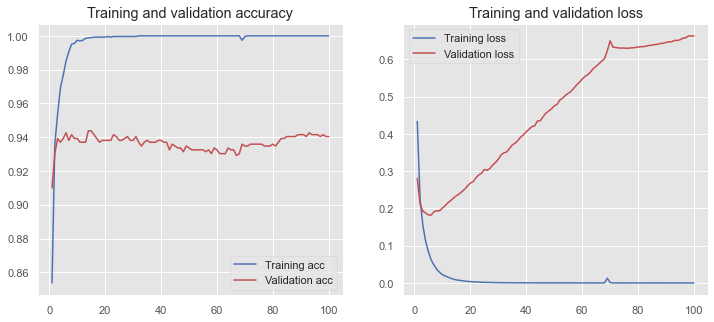

In [102]:
plot_history(history)